 ╔══<i><b>&nbsp;Alai-DeepLearning&nbsp;</b></i>══════════════════════════════════╗
###  &nbsp;&nbsp; **✎&nbsp;&nbsp;Week 5. machine learning basis**
# Homework 2. Multi classification

### _Objective_
Tensorflow 을 이용해서 One Vs All 전략을 이용해 다중 classification 모델을 생성합니다.

아래 순서에 맞게 프로그램을 작성해 주세요.
1. Setosa  Vs Versicolour, Virginica 모델 구현
 - 학습시 Tensorboard 을 이용해 loss 와 accuracy 을 추적해 주세요. 
 - 학습 동안 acc 가 가장 높은 모델을 저장해 주세요.
2. Versicolour Vs Setosa, Virginica 모델 구현
  - 학습시 Tensorboard 을 이용해 loss 와 accuracy 을 추적해 주세요. 
 - 학습 동안 acc 가 가장 높은 모델을 저장해 주세요.
3. Virginica Vs Setosa, Versicolour 모델 구현
  - 학습시 Tensorboard 을 이용해 loss 와 accuracy 을 추적해 주세요. 
 - 학습 동안 acc 가 가장 높은 모델을 저장해 주세요.
4. 저장된 3개의 모델을 불러온 후 가장 높은 확률이 나오는 값을 선택합니다. <br>
가령 아래의 경우 **Versicolour** 을 선택합니다.

| class        | probabilty |
|--------------|------------|
| Setosa       | 0.7        |
| Versicolour  | 0.9        |
| Virginica    | 0.3        |

학습이 끝난후 모든 데이터를 평가한 후 accuracy 을 측정합니다.

╚═══════════════════════════════════════════════╝

In [0]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.datasets import load_iris

In [0]:
# 아래 코드를 실행해 주세요
np.random.seed(1)
iris = load_iris()

xs = iris['data']
ys = iris['target']
ys_name = iris['target_names']

concat = np.concatenate([xs, np.reshape(ys, [-1, 1])], axis=1)
column = ["sepal_length", "sepal_width", "petal_length", "petal_width", "target"]
df = pd.DataFrame(concat, columns=column)

## normalization
temp = df.loc[:,"sepal_length":"target"]
df.loc[:,"sepal_length":"target"] = (temp - temp.min()) / (temp.max() - temp.min())
xs = df.loc[:,"sepal_length":"petal_width"].values
ys = df.loc[:,"target"].values

In [0]:
graph = tf.Graph()
with graph.as_default() :
    def sigmoid(logits) :
        return 1 / ( 1 + tf.exp(-logits))  # 공식을 잘못써서 계산이 잘못되었었다! ㅠㅠ
    
    def cee(pred, ys) :
        return -1 * tf.reduce_mean( ys*tf.log(pred) + (1-ys)*tf.log(1-pred) )
      
    def cal_acc(pred, ys_label) :
        # acc = tf.reduce_mean(tf.cast(tf.equal(pred_cls, self.ys), tf.float32), name='acc')
        return tf.reduce_mean(tf.cast(tf.equal(pred, ys_label), tf.float64), name='acc')

    with tf.name_scope('initial_value') :
        weights = tf.Variable(np.random.normal(loc=0.0, scale=0.1, size=(4,1)), dtype=tf.float64, name='weights')
        bias = tf.Variable(np.random.normal(loc=0.0, scale=0.1, size=()), dtype=tf.float64, name='bias') 
        ys_label = tf.placeholder( dtype=tf.float64, shape=(None,), name='ys_label') # shape=(None, )
        ### size=() --> 0차원짜리, size=(1) --> 1차원짜리 생성! shape는 (1,)가 된다.
        
    with tf.name_scope('calculate') :
        logits = tf.matmul(xs, weights) + bias # logits.shape=(150,1) // xs.shape=(150,4), weights.shape=(4,1), bias.shape=()
        logits = tf.reshape(logits, [-1])  
        pred = sigmoid(logits) # pred.shape(150,) 
        loss = cee(pred, ys_label) # loss.shape() // ys.shape=(150,) // pred값이 높아야(확률값) loss가 줄어든다
        tf.add_to_collection('loss', tf.GraphKeys.LOSSES)
        cutvalue = tf.constant(0.7, dtype=tf.float64)
        acc = cal_acc(pred > cutvalue, tf.cast(ys_label, tf.bool)) 
    
    with tf.name_scope('gradient') :
        gradient = pred - ys_label    # gradient.shape = [150,]
        d_w = tf.matmul(tf.transpose(xs), tf.reshape(gradient, [-1, 1])) # d_w.shape=(4,1) // tf.transpose(xs).shape=[4,150], 
        d_b = tf.reduce_mean(gradient, axis=0) # d_b.shape=()
        
    with tf.name_scope('update_weights') :
        lr = tf.constant(0.01, shape=(), dtype=tf.float64)
        train_op = tf.group( 
            # Update 'ref' by subtracting 'value' from it.
            # tf.assign( ref, value, ... )
            # value항목에서 -값을 붙여서 weights가 잘못 계산되고 있었다..
            tf.assign_sub(weights, d_w * lr, name='update_weights'),  # weights.shape=(4,1), d_w.shape(4,1)
            tf.assign_sub(bias, d_b * lr, name='update_bias'),     # bias.shape=(), d_b.shape=(), lr.shape=()
            name = 'train_op')

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
tf.reset_default_graph()

with graph.as_default() :
    sess = tf.Session()
    init = tf.global_variables_initializer()
    sess.run(init)
     
    epoc = 500    

    acc_list_final = []
    loss_list_final = []
    flowers_list = [0, 0.5, 1] ## label info
    
    saver = tf.train.Saver()
    final_acc = 0
    final_idx = 0
    
    # 첫번하고 restore하고 다시 돌려본다.
    for k in range(3) :
        ys_label1 = np.where(ys == flowers_list[k], [1], [0])  # Setosa와 다른 꽃들과 비교
        acc_list = [] 
        loss_list = []
        best_acc = 0
        model_dir = './tmp/model_' + str(k)
        print(model_dir)
        for i in range(epoc) :
            _, loss_, acc_ = sess.run([train_op, loss, acc], feed_dict={ ys_label : ys_label1 })
            acc_list.append(acc_)
            loss_list.append(loss_)
            
            ### Save Model Weights
            # tf.cond(조건, 참일경우, 거짓일경우)
            if acc_ > best_acc :
                best_acc = acc_
                saver.save(sess, model_dir)
                            
        acc_list_final.append(acc_list)
        loss_list_final.append(loss_list)
        if best_acc > final_acc :
            final_idx = k
            final_acc = best_acc

./tmp/model_0
./tmp/model_1
./tmp/model_2


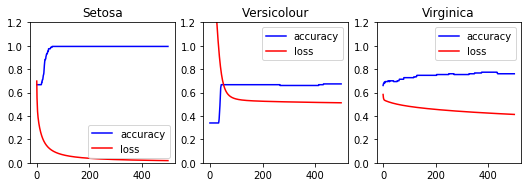

In [0]:
    fig = plt.figure(figsize=(15, 15))
    
    ax = fig.add_subplot(5,5,1)
    ax.plot(np.arange(0, epoc, 1), acc_list_final[0], label="accuracy", color='blue')
    ax.plot(np.arange(0, epoc, 1), loss_list_final[0], label="loss", color='red')
    ax.legend()
    ax.set_ylim(0, 1.2)
    ax.set_title("Setosa")
    
    ax = fig.add_subplot(5,5,2)
    ax.plot(np.arange(0, epoc, 1), acc_list_final[1], label="accuracy", color='blue')
    ax.plot(np.arange(0, epoc, 1), loss_list_final[1], label="loss", color='red')
    ax.legend()
    ax.set_ylim(0, 1.2)
    ax.set_title("Versicolour")

    ax = fig.add_subplot(5,5,3)
    ax.plot(np.arange(0, epoc, 1), acc_list_final[2], label="accuracy", color='blue')
    ax.plot(np.arange(0, epoc, 1), loss_list_final[2], label="loss", color='red')
    ax.legend()
    ax.set_ylim(0, 1.2)
    ax.set_title("Virginica")
    
    plt.show()

In [0]:
### TODO : 저장된 데이터 불러오기

with graph.as_default() :
    
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())
    model_dir = './tmp/model_' + str(final_idx) + '.meta'
    tf.train.import_meta_graph(model_dir)  # 저장된 graph불러오기
    model_name = 'tmp/model_' + str(final_idx) 
    saver.restore(sess, model_name)  
    # 저장해 놓은 변수의 값들을 graph의 초기화 값으로 넣어준다.  
    # model번호는 윗부분 코드에서 골라서 변수로 넘겨줘야 한다.

    ys_label1 = graph.get_tensor_by_name('initial_value/ys_label:0')
    acc = graph.get_tensor_by_name('calculate/acc:0')
    loss = graph.get_collection(tf.GraphKeys.LOSSES) # return type : list
    train_op = graph.get_collection(tf.GraphKeys.TRAIN_OP)
    
    flowers_list = [0, 0.5, 1] ## label info
    acc_list = [] 
    loss_list = []
    for k in range(3) :
        ys_label1 = np.where(ys == flowers_list[k], [1], [0])  # Setosa와 다른 꽃들과 비교
        _, loss_, acc_ = sess.run([train_op, loss, acc], feed_dict={ ys_label : ys_label1 })
        acc_list.append(acc_)
        loss_list.append(loss_)


INFO:tensorflow:Restoring parameters from tmp/model_0


#  

---

    Copyright(c) 2019 by Public AI. All rights reserved.
    Writen by PAI, SangJae Kang ( rocketgrowthsj@publicai.co.kr )  last updated on 2019/03/22

---